In [60]:
from dl import queryClient as qc
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator,FixedLocator)
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np
from matplotlib.patches import Polygon, Ellipse
from matplotlib.colors import LogNorm
from astropy.io import ascii
from astropy.io import fits
from astropy.table import Table, Column
import statistics as st
from numpy import nan
from dlnpyutils import utils as dln
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import astropy.coordinates as coord
import astropy.units as u
import gala.coordinates as gc
from gala.coordinates import MagellanicStreamNidever08

import lmcfit
from lmfit import Minimizer, Parameters, report_fit

from dl import queryClient as qc
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np
from matplotlib.colors import LogNorm
from astropy.io import ascii
from astropy.io import fits
from astropy.table import Table
import statistics as st
from numpy import nan
from dlnpyutils import utils as dln
from scipy.stats import binned_statistic_2d



# Load in Catalogs

In [5]:
lmc_combined_for_fit = Table.read('/Users/slaterjonesoden/Desktop/LMC_Periphery/LMC_Periphery_Project/combined_catalogs/combined_catalog_for_Full_Kinematic_Fit/lmc_combined_for_fit.fits')

gaiadr3_lmc = Table.read('/Users/slaterjonesoden/Desktop/LMC_Periphery/LMC_Periphery_Project/Gaia_dr3/full_catalog/RGB/gaiadr3_lmc.fits')

# gaiadr3_lmc_good = Table.read('/Users/slaterjonesoden/Desktop/LMC_Periphery/LMC_Periphery_Project/Gaia_dr3/full_catalog/catalogs_with_model/gaiadr3_lmc_good.fits')




In [3]:
gaiadr3_30deg_RGB_lmc = Table.read('/Users/slaterjonesoden/Desktop/LMC_Periphery/LMC_Periphery_Project/Gaia_dr3/full_catalog/archive/catalogs_with_model/catalogs_with_3D_model/gaiadr3_30deg_RGB_lmc.fits')



# Visualize 30 deg Gaia dr3 query

(-28.0, 25.0)

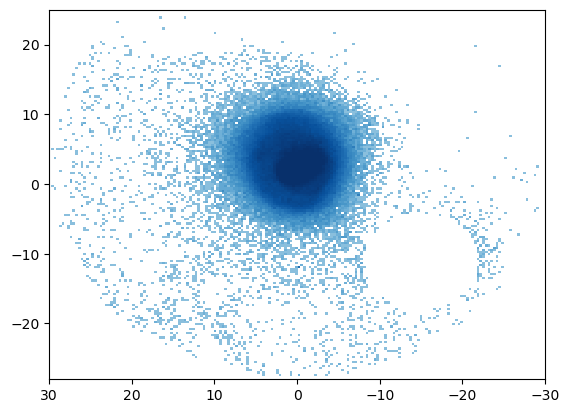

In [132]:
plt.hist2d(gaiadr3_30deg_RGB_lmc['mlon'],gaiadr3_30deg_RGB_lmc['mlat'],bins=180,norm=LogNorm(vmin=0.01,vmax=500),cmap='Blues')

plt.xlim(30,-30)
plt.ylim(-28,25)

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.colors import Normalize
from matplotlib.patches import Polygon
from shapely.geometry import Polygon as ShapelyPolygon, Point

# Extract data
mlon = gaiadr3_30deg_RGB_lmc_3dvel['mlon']
mlat = gaiadr3_30deg_RGB_lmc_3dvel['mlat']
dist_mag = gaiadr3_30deg_RGB_lmc_3dvel['distance']

# Generate Voronoi tessellation
points = np.column_stack((mlon, mlat))
vor = Voronoi(points)

# Function to compute the mean for a region
def compute_region_mean(region, dist_mag, points):
    # If the region index is -1 or has no valid vertices, skip it
    if -1 in region or len(region) == 0:
        return np.nan

    # Convert Voronoi vertices to a polygon
    polygon = ShapelyPolygon(vor.vertices[region])
    if not polygon.is_valid or polygon.area == 0:
        return np.nan

    # Find points inside the polygon
    contained_points = [i for i, p in enumerate(points) if polygon.contains(Point(p))]
    if len(contained_points) == 0:
        return np.nan

    # Compute the mean of dist_mag for points inside the polygon
    return np.mean(dist_mag[contained_points])

# Compute values for each Voronoi region
region_means = []
for region_index in vor.regions:
    region_means.append(compute_region_mean(region_index, dist_mag, points))

# Plot the Voronoi diagram
fig, ax = plt.subplots(figsize=(10, 8))
norm = Normalize(vmin=40, vmax=60)  # Normalize color scale
cmap = plt.cm.bwr

for region_index, mean_value in zip(vor.regions, region_means):
    if -1 in region_index or len(region_index) == 0:
        continue
    polygon = [vor.vertices[i] for i in region_index]
    patch = Polygon(polygon, facecolor=cmap(norm(mean_value)), edgecolor='black', lw=0.5)
    ax.add_patch(patch)

# Plot Voronoi points for reference
ax.scatter(mlon, mlat, c='k', s=1, label='Data points')

# Set up the color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Mean dist_mag')

# Set axis limits and labels
ax.set_xlim(mlon.min(), mlon.max())
ax.set_ylim(mlat.min(), mlat.max())
ax.set_xlabel('MLON')
ax.set_ylabel('MLAT')
ax.set_title('Voronoi Binning')

plt.legend()
plt.show()


KeyboardInterrupt: 

## Calculate in-plane distance if catalog doesn't already have

In [110]:
del gaiadr3_lmc_good['distance']

In [104]:
def distance(catalog):
    
    # Define Do, i, and theta
    Do = (50100.0 * u.pc).value # distance to LMC CoM in pc
    i = 29.2 * u.deg
    theta = 148.7 * u.deg
    
    # Convert angles from degrees to radians
    rho = catalog['rho'].to(u.radian).value
    bphi = catalog['bphi'].to(u.radian).value
    i = i.to_value(u.radian)  
    theta = theta.to_value(u.radian)

    distance = np.zeros(len(catalog)) * u.pc
    
    for idx in range(len(catalog)):
    
        D = (Do * np.cos(i))/(np.cos(i) * np.cos(rho[idx]) - np.sin(i) * np.sin(rho[idx]) * np.sin(bphi[idx] - theta)) * u.pc
                
        distance[idx] = D 
        
    catalog['distance'] = distance
    
    return catalog


(array([1.0500e+02, 9.3000e+01, 9.6000e+01, 1.2200e+02, 2.1300e+02,
        3.6500e+02, 6.7400e+02, 1.9230e+03, 5.2440e+03, 1.1706e+04,
        1.9295e+04, 2.2738e+04, 2.7935e+04, 3.8337e+04, 6.4708e+04,
        8.6919e+04, 6.8784e+04, 4.4416e+04, 2.6385e+04, 1.7608e+04,
        1.2865e+04, 6.8770e+03, 3.3400e+03, 1.6610e+03, 7.7400e+02,
        4.8300e+02, 2.9400e+02, 2.1100e+02, 1.4100e+02, 1.2500e+02,
        1.0700e+02, 1.4100e+02, 8.5000e+01, 7.7000e+01, 5.1000e+01,
        5.1000e+01, 3.2000e+01, 2.9000e+01, 4.2000e+01, 2.6000e+01,
        3.2000e+01, 2.3000e+01, 2.7000e+01, 2.6000e+01, 1.7000e+01,
        2.1000e+01, 6.0000e+00, 1.8000e+01, 1.6000e+01, 9.0000e+00,
        1.1000e+01, 9.0000e+00, 1.3000e+01, 1.4000e+01, 8.0000e+00,
        1.3000e+01, 1.5000e+01, 2.1000e+01, 5.0000e+00, 7.0000e+00,
        1.3000e+01, 8.0000e+00, 8.0000e+00, 1.2000e+01, 1.3000e+01,
        1.6000e+01, 8.0000e+00, 1.4000e+01, 7.0000e+00, 1.0000e+01,
        1.0000e+01, 9.0000e+00, 1.5000e+01, 1.30

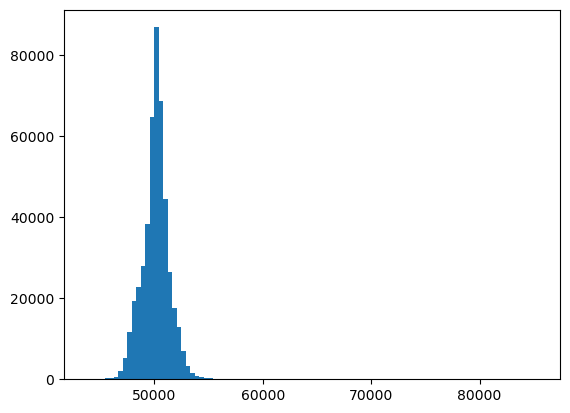

In [22]:
plt.hist(gaiadr3_30deg_RGB_lmc['distance'],bins=100)

# Calcuate v2int and v3int

In [23]:
########### My first attempt at calculating v2int and v3int ############

# def v2v3int(catalog):
#     # Define constants
#     i = 29.2 * u.deg
#     i = i.to_value(u.rad)
#     theta = 148.7 * u.deg
#     theta = theta.to_value(u.rad)
    
#     # ra, dec CM of LMC
#     alpha0 = 80.44229 * u.deg 
#     alpha0 = alpha0.to_value(u.rad)
#     delta0 = -69.2722 * u.deg
#     delta0 = delta0.to_value(u.rad)

#     # Convert angles and proper motions
#     rho = catalog['rho'].to(u.rad).value
#     bphi = catalog['bphi'].to(u.rad).value
#     muw = -1 * catalog['pmra']
#     mun = catalog['pmdec']
#     alpha = (catalog['ra'].value * u.deg).to(u.rad).value
#     delta = (catalog['dec'].value * u.deg).to(u.rad).value
#     D = catalog['distance'].to(u.kpc).value

#     # Correct for bulk CM motion
#     muwint = (muw - (-1.85930936 * u.mas / u.yr)).value
#     munint = (mun - (0.37472295 * u.mas / u.yr)).value

#     # Calculate cosg and sing for all stars
#     cosg = (np.sin(delta) * np.cos(delta0) * np.cos(alpha - alpha0) - np.cos(delta) * np.sin(delta0)) / np.sin(rho)
#     sing = (np.cos(delta0) * np.sin(alpha - alpha0)) / np.sin(rho)

#     # Compute v2int and v3int for all stars
#     v2int = (4.7403885 * D * (-1 * sing * muwint + cosg * munint)) * u.km / u.s
#     v3int = (4.7403885 * D * (-1 * cosg * muwint - sing * munint)) * u.km / u.s

#     # Add results to the catalog
#     catalog['v2int'] = v2int
#     catalog['v3int'] = v3int

#     return catalog


In [68]:
########### My second attempt at calculating v2int and v3int ############


def v2v3int(catalog):
     
    # Load in LMC Parameter File:
    params_fit_rsg_edr3 = Parameters() 
    fp = open('params_fit_rsg_edr3.json')
    params_fit_rsg_edr3.load(fp)
    fp.close()
    
    inc = params_fit_rsg_edr3['inc'] * u.deg
    th = params_fit_rsg_edr3['th'] * u.deg
    
    muw = params_fit_rsg_edr3['muw'] * u.mas/u.yr
    mun = params_fit_rsg_edr3['mun'] * u.mas/u.yr 
    d0 = params_fit_rsg_edr3['d0'] * u.pc
    aro = params_fit_rsg_edr3['aro'] * u.rad
    dro = params_fit_rsg_edr3['dro'] * u.rad
        
    ra = catalog['ra'].to(u.rad)
    dec = catalog['dec'].to(u.rad)
    
    rho = catalog['rho'].to(u.rad)
    bphi = catalog['bphi'].to(u.rad)
    phi = ((catalog['bphi'].value * u.deg) + 90 * u.deg).value * u.rad
    
    pmw = -1 * catalog['pmra'].to(u.mas/u.yr)
    pmn = catalog['pmdec'].to(u.mas/u.yr)
    
    # Define theta_t for transerve velocity vector
    tht = np.arctan2(-muw,mun)
    if tht<0:
        tht = tht + 2*np.pi*u.rad

    vt = (np.sqrt(mun**2+muw**2)*d0).to(u.rad*u.km/u.s).value*u.km/u.s
        
    ar=ra.to(u.rad)
    dr=dec.to(u.rad)
    ar[ar-aro > np.pi*u.rad] = ar[ar-aro > np.pi*u.rad] - 2*np.pi*u.rad # to set ar-aro between -pi,pi
    ar[ar-aro < -np.pi*u.rad] = ar[ar-aro < -np.pi*u.rad] + 2*np.pi*u.rad # to set ar-aro between -pi,pi
    
    # define rho and phi
    rho=np.arccos((np.cos(dr)*np.cos(dro)*np.cos(ar-aro)+np.sin(dr)*np.sin(dro)))
    tphi=(np.sin(dr)*np.cos(dro)-np.cos(dr)*np.sin(dro)*np.cos(ar-aro))/(-np.cos(dr)*np.sin(ar-aro))
    tphi[np.isnan(tphi)]=0
    q2=((aro-ar) < 0) & ((dr-dro) > 0)
    q3=((aro-ar) < 0) & ((dr-dro) < 0)
    q4=((aro-ar) > 0) & ((dr-dro) < 0)
    phi=np.arctan(tphi)

    if (len(phi[q2])>0): phi[q2]=phi[q2]+np.pi*u.rad
    if (len(phi[q3])>0): phi[q3]=phi[q3]+np.pi*u.rad
    if (len(phi[q4])>0): phi[q4]=phi[q4]+2*np.pi*u.rad
    bphi=phi-np.pi/2*u.rad
    neg=(bphi < 0)
    if (len(bphi[neg])>0): bphi[neg]=bphi[neg]+2*np.pi*u.rad
    phi_th = bphi - th.to(u.rad)
    
    # Geometric factors 
    c1=(np.cos(inc)*np.cos(rho)-np.sin(inc)*np.sin(rho)*np.sin(phi_th))/(d0.to(u.km)*np.cos(inc))
    cosg=(np.sin(dr)*np.cos(dro)*np.cos(ar-aro)-np.cos(dr)*np.sin(dro))/np.sin(rho)
    sing=(np.cos(dro)*np.sin(ar-aro))/np.sin(rho)
    cosg[np.isnan(cosg)]=0.
    sing[np.isnan(sing)]=-1.
    
    # Correct for CM motion
    pmwint = pmw - muw
    pmnint = pmn - mun
    
    v2int=(1./c1*(-sing*pmwint.to(u.rad/u.s) + cosg*pmnint.to(u.rad/u.s))).value*u.km/u.s
    v3int=(1./c1*(-cosg*pmwint.to(u.rad/u.s) - sing*pmnint.to(u.rad/u.s))).value*u.km/u.s
    
    catalog['v2int'] = v2int
    catalog['v3int'] = v3int
    
    return catalog

In [69]:
gaiadr3_30deg_RGB_lmc = v2v3int(gaiadr3_30deg_RGB_lmc)

In [71]:
a = np.where(gaiadr3_30deg_RGB_lmc['v2int'] > 200)

b = np.where(gaiadr3_30deg_RGB_lmc['v2int'] < -200)

print(len(gaiadr3_30deg_RGB_lmc))
print(len(gaiadr3_30deg_RGB_lmc[a]))
print(len(gaiadr3_30deg_RGB_lmc[b]))



a = np.where(gaiadr3_30deg_RGB_lmc['v3int'] > 200)

b = np.where(gaiadr3_30deg_RGB_lmc['v3int'] < -200)

print(len(gaiadr3_30deg_RGB_lmc))
print(len(gaiadr3_30deg_RGB_lmc[a]))
print(len(gaiadr3_30deg_RGB_lmc[b]))


465699
361
1359
465699
63
9322


### Visual results for v2int and v3int

Text(0, 0.5, '$B_{MS}$ (deg)')

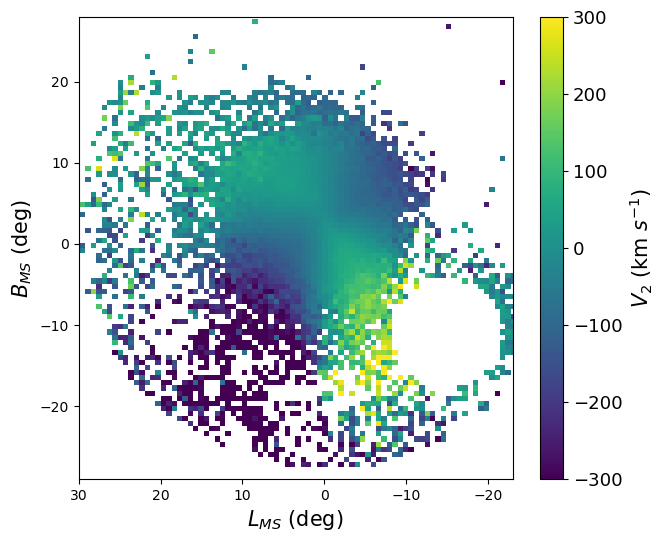

In [82]:
fig,ax = plt.subplots(1,1,figsize=(7,6))

lmc_catalog = Table.read('/Users/slaterjonesoden/Desktop/LMC_Periphery/LMC_Periphery_Project/catalogs_with_LMC_3D_Velocities/SPOKE/lmc_catalog.fits')

pmdist = np.sqrt((lmc_catalog['pmml'] - 1.7)**2 + (lmc_catalog['pmmb']  - 0.54)**2)

spoke = lmc_catalog[np.where((pmdist < 2) & (lmc_catalog['VHELIO'] > 250))]

# plt.scatter(spoke['mlon'],spoke['mlat'],c=spoke['v2'],cmap='viridis',s=2)

result,xedge,yedge,binnumber = binned_statistic_2d(gaiadr3_30deg_RGB_lmc['mlon'], gaiadr3_30deg_RGB_lmc['mlat'],
                gaiadr3_30deg_RGB_lmc['v2int'], statistic = "mean",bins=90)

im = ax.imshow(result.T,extent=[xedge[0],xedge[-1],yedge[0],yedge[-1]], origin="lower", aspect="auto", cmap="viridis",vmin=-300,vmax=300)


ax.set_xlim(30,-23)
ax.set_ylim(-29,28)

cbar = plt.colorbar(im)
cbar.set_label('$V_{2}$ (km $s^{-1}$)', fontsize=15)
cbar.ax.tick_params(labelsize=13)

ax.set_xlabel('$L_{MS}$ (deg)', fontsize=15)
ax.set_ylabel('$B_{MS}$ (deg)', fontsize=15)

Text(0, 0.5, '$B_{MS}$ (deg)')

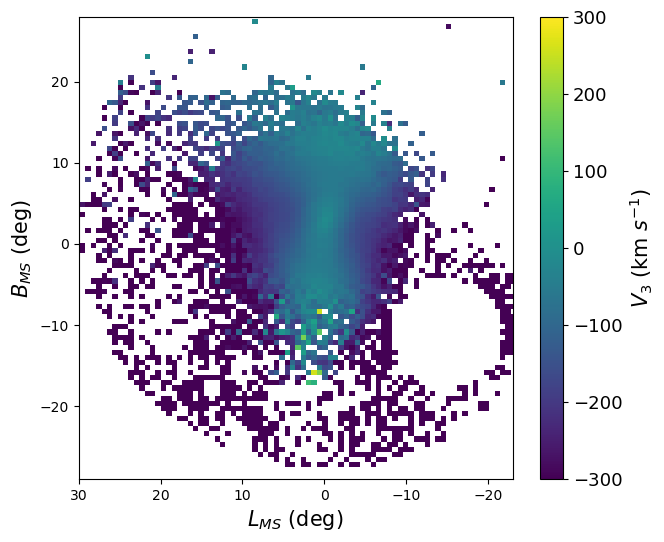

In [83]:
fig,ax = plt.subplots(1,1,figsize=(7,6))

result,xedge,yedge,binnumber = binned_statistic_2d(gaiadr3_30deg_RGB_lmc['mlon'], gaiadr3_30deg_RGB_lmc['mlat'],
                gaiadr3_30deg_RGB_lmc['v3int'], statistic = "mean",bins=90)

im = ax.imshow(result.T,extent=[xedge[0],xedge[-1],yedge[0],yedge[-1]], origin="lower", aspect="auto", cmap="viridis",vmin=-300,vmax=300)


ax.set_xlim(30,-23)
ax.set_ylim(-29,28)

cbar = plt.colorbar(im)
cbar.set_label('$V_{3}$ (km $s^{-1}$)', fontsize=15)
cbar.ax.tick_params(labelsize=13)

ax.set_xlabel('$L_{MS}$ (deg)', fontsize=15)
ax.set_ylabel('$B_{MS}$ (deg)', fontsize=15)

# Now calcuate Vint from v2int and v3int

In [33]:
########### My first attempt at calculating Vint ############



# def vint(catalog):
#     # Define constants
#     i = 29.2 * u.deg
#     theta = 148.7 * u.deg
#     i = i.to_value(u.rad)
#     theta = theta.to_value(u.rad)
    
#     # Convert angles from degrees to radians
#     rho = catalog['rho'].value
#     bphi = catalog['bphi'].value
    
#     muw = -1 * catalog['pmra'].value * u.mas/u.yr
#     mun = catalog['pmdec'].value * u.mas/u.yr
    
#     v2 = catalog['v2int'].value * u.km / u.s
#     v3 = catalog['v3int'].value * u.km / u.s
    
#     # Calculate f1 and f2 using vectorized operations
#     f1 = np.cos(i) * np.sin(rho) + np.sin(i) * np.cos(rho) * np.sin(bphi - theta)
#     f2 = np.sqrt(np.cos(i)**2 * np.cos(bphi - theta)**2 + np.sin(bphi - theta)**2)
    
#     # Calculate theta_t for all stars
#     theta_t = np.arctan2(-muw.value, mun.value)
    
#     # Determine the sign (s = ±1) for all stars
#     s = np.where(
#         ((90 * u.deg).to_value(u.rad) < (bphi - theta_t)) & ((bphi - theta_t) < (270 * u.deg).to_value(u.rad)),-1,1)
    
#     # Compute Vint for all stars
#     Vint = s * np.sqrt(v2**2 + v3**2) / (np.sqrt((f1 / f2)**2 * np.sin(i)**2 * np.cos(bphi - theta)**2 + f2**2))
    
#     # Add Vint to the catalog
#     catalog['vint'] = Vint
    
#     return catalog


In [133]:
########### My Second attempt at calculating Vint ############


def vint(catalog):
    
    # Load in LMC Parameter File:
    params_fit_rsg_edr3 = Parameters() 
    fp = open('params_fit_rsg_edr3.json')
    params_fit_rsg_edr3.load(fp)
    fp.close()
    
    inc = params_fit_rsg_edr3['inc'] * u.deg
    th = params_fit_rsg_edr3['th'] * u.deg
    
    mw = params_fit_rsg_edr3['muw'] * u.mas/u.yr
    mun = params_fit_rsg_edr3['mun'] * u.mas/u.yr 
    d0 = params_fit_rsg_edr3['d0'] * u.pc
    aro = params_fit_rsg_edr3['aro'] * u.rad
    dro = params_fit_rsg_edr3['dro'] * u.rad
        
    ra = catalog['ra'].to(u.rad)
    dec = catalog['dec'].to(u.rad)
    
    rho = catalog['rho'].to(u.rad)
    bphi = catalog['bphi'].to(u.rad)
    phi = ((catalog['bphi'].value * u.deg) + 90 * u.deg).value * u.rad
    
    pmw = -1 * catalog['pmra'].to(u.mas/u.yr)
    pmn = catalog['pmdec'].to(u.mas/u.yr)
    
    ar=ra.to(u.rad)
    dr=dec.to(u.rad)
    ar[ar-aro > np.pi*u.rad] = ar[ar-aro > np.pi*u.rad] - 2*np.pi*u.rad # to set ar-aro between -pi,pi
    ar[ar-aro < -np.pi*u.rad] = ar[ar-aro < -np.pi*u.rad] + 2*np.pi*u.rad # to set ar-aro between -pi,pi
    
    # define rho and phi
    rho=np.arccos((np.cos(dr)*np.cos(dro)*np.cos(ar-aro)+np.sin(dr)*np.sin(dro)))
    tphi=(np.sin(dr)*np.cos(dro)-np.cos(dr)*np.sin(dro)*np.cos(ar-aro))/(-np.cos(dr)*np.sin(ar-aro))
    tphi[np.isnan(tphi)]=0
    q2=((aro-ar) < 0) & ((dr-dro) > 0)
    q3=((aro-ar) < 0) & ((dr-dro) < 0)
    q4=((aro-ar) > 0) & ((dr-dro) < 0)
    phi=np.arctan(tphi)

    if (len(phi[q2])>0): phi[q2]=phi[q2]+np.pi*u.rad
    if (len(phi[q3])>0): phi[q3]=phi[q3]+np.pi*u.rad
    if (len(phi[q4])>0): phi[q4]=phi[q4]+2*np.pi*u.rad
        
    bphi=phi-np.pi/2*u.rad
    neg=(bphi < 0)
    
    if (len(bphi[neg])>0): bphi[neg]=bphi[neg]+2*np.pi*u.rad
    phi_th = bphi - th.to(u.rad)
    
    
    # Define theta_t for transerve velocity vector
    tht = np.arctan2(-muw,mun)
    if tht<0:
        tht = tht + 2*np.pi*u.rad
        
        
    v2int = catalog['v2int'].to(u.km/u.s)
    v3int = catalog['v3int'].to(u.km/u.s)
    
    vtang = np.sqrt((v2int)**2 + (v3int)**2)
    
    f1 = ((np.cos(inc) * np.sin(rho)) + (np.sin(inc) * np.cos(rho) * np.sin(phi_th)))
    
    f2 =  np.sqrt((np.cos(inc)**2 * np.cos(phi_th)**2) + np.sin(phi_th)**2)
        
    # Determine the spin sign (s = ±1) for all stars
    bphi=phi-np.pi/2*u.rad
    neg=(bphi < 0)
    
    if (len(bphi[neg])>0): bphi[neg]=bphi[neg]+2*np.pi*u.rad
    bphi_tht = bphi - tht.to(u.rad)

    s = np.where(((np.pi/2) * u.rad < bphi_tht) & (bphi_tht < (3*np.pi/2) * u.rad), -1, 1)
    
    f = np.sqrt((f1/f2)**2 * np.sin(inc)**2 * np.cos(phi_th)**2 + f2**2)
                  
    vint = s * (vtang/f)
    
    # Add Vint to the catalog
    catalog['vint'] = vint
    
    return catalog

In [129]:
gaiadr3_30deg_RGB_lmc = vint(gaiadr3_30deg_RGB_lmc)

## Visual Results for Vint

Text(0, 0.5, '$B_{MS}$ (deg)')

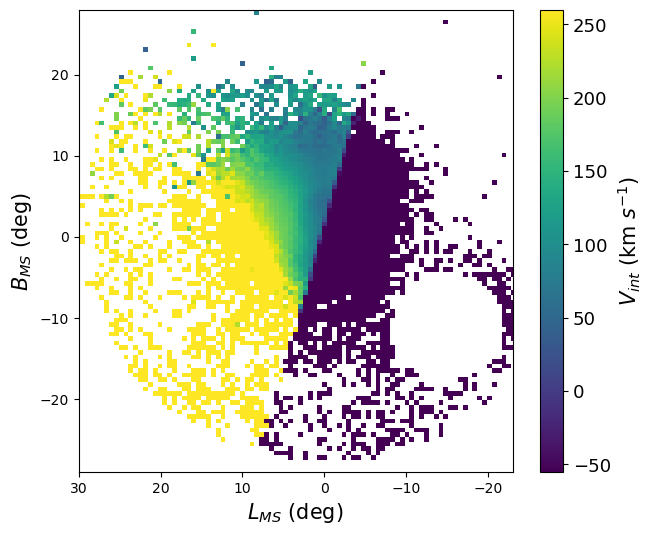

In [131]:
fig,ax = plt.subplots(1,1,figsize=(7,6))


# a = np.where(gaiadr3_30deg_RGB_lmc['vint'] > -60)

result,xedge,yedge,binnumber = binned_statistic_2d(gaiadr3_30deg_RGB_lmc['mlon'], gaiadr3_30deg_RGB_lmc['mlat'],
                gaiadr3_30deg_RGB_lmc['vint'], statistic = "mean",bins=100)

im = ax.imshow(result.T,extent=[xedge[0],xedge[-1],yedge[0],yedge[-1]], origin="lower", aspect="auto", cmap="viridis",vmin=-55,vmax=260)


ax.set_xlim(30,-23)
ax.set_ylim(-29,28)

cbar = plt.colorbar(im)
cbar.set_label('$V_{int}$ (km $s^{-1}$)', fontsize=15)
cbar.ax.tick_params(labelsize=13)

ax.set_xlabel('$L_{MS}$ (deg)', fontsize=15)
ax.set_ylabel('$B_{MS}$ (deg)', fontsize=15)


Text(0, 0.5, '$B_{MS}$ (deg)')

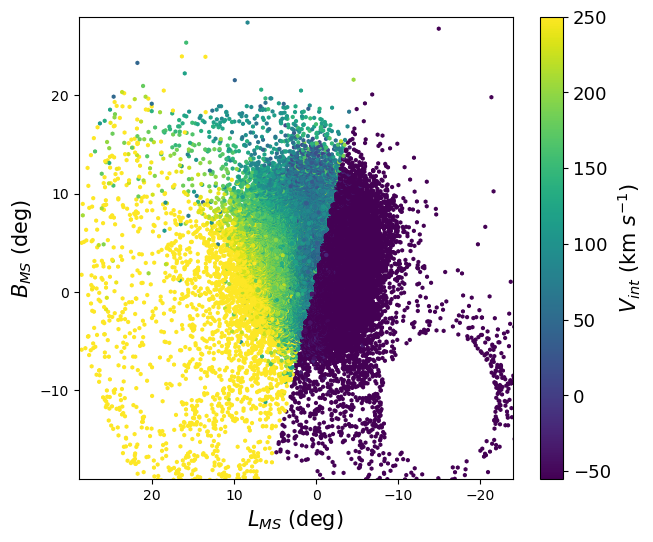

In [118]:
fig,ax = plt.subplots(1,1,figsize=(7,6))

# result,xedge,yedge,binnumber = binned_statistic_2d(lmc_combined_for_fit['mlon'], lmc_combined_for_fit['mlat'],
#                 lmc_combined_for_fit['vint'], statistic = "mean",bins=90)

# im = ax.imshow(result.T,extent=[xedge[0],xedge[-1],yedge[0],yedge[-1]], origin="lower", aspect="auto", cmap="viridis",vmin=-50,vmax=200)

im = plt.scatter(gaiadr3_30deg_RGB_lmc['mlon'], gaiadr3_30deg_RGB_lmc['mlat'],
                c=gaiadr3_30deg_RGB_lmc['vint'],cmap='viridis',marker='h',s=5,vmin=-55,vmax=250)

ax.set_xlim(29,-24)
ax.set_ylim(-19,28)

cbar = plt.colorbar(im)
cbar.set_label('$V_{int}$ (km $s^{-1}$)', fontsize=15)
cbar.ax.tick_params(labelsize=13)

ax.set_xlabel('$L_{MS}$ (deg)', fontsize=15)
ax.set_ylabel('$B_{MS}$ (deg)', fontsize=15)

# Compare Vint results with result calculated strictly from v2 and v3 (i.e. Vint on with respect to the sky plane)

In [ ]:
def v(catalog):
    
    v2 = catalog['v2']
    v3 = catalog['v3']
    
    v = np.sqrt((v2)**2 + (v3)**2)
    
    catalog['v_tang'] = v
    
    return catalog

In [ ]:
gaiadr3_30deg_RGB_lmc = v(gaiadr3_30deg_RGB_lmc)
spoke = v(spoke)

Text(0, 0.5, '$B_{MS}$ (deg)')

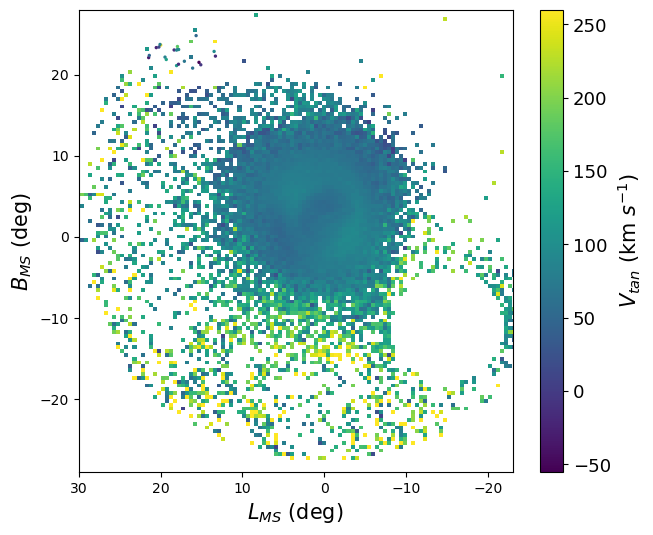

In [135]:
fig,ax = plt.subplots(1,1,figsize=(7,6))


plt.scatter(spoke['mlon'],spoke['mlat'],c=spoke['v_tang'],cmap='viridis',s=2)


result,xedge,yedge,binnumber = binned_statistic_2d(gaiadr3_30deg_RGB_lmc['mlon'], gaiadr3_30deg_RGB_lmc['mlat'],
                gaiadr3_30deg_RGB_lmc['v_tang'], statistic = "mean",bins=120)

im = ax.imshow(result.T,extent=[xedge[0],xedge[-1],yedge[0],yedge[-1]], origin="lower", aspect="auto", cmap="viridis",
              vmin=-55,vmax=260)


ax.set_xlim(30,-23)
ax.set_ylim(-29,28)

cbar = plt.colorbar(im)
cbar.set_label('$V_{tan}$ (km $s^{-1}$)', fontsize=15)
cbar.ax.tick_params(labelsize=13)

ax.set_xlabel('$L_{MS}$ (deg)', fontsize=15)
ax.set_ylabel('$B_{MS}$ (deg)', fontsize=15)



Text(0, 0.5, '$B_{MS}$ (deg)')

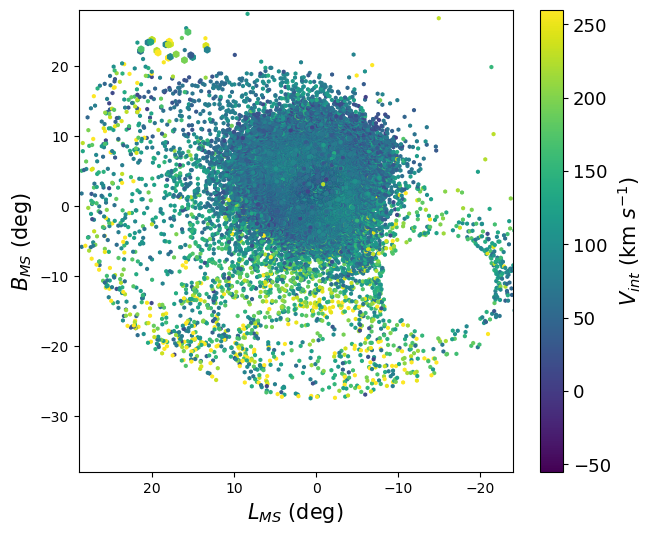

In [136]:
fig,ax = plt.subplots(1,1,figsize=(7,6))

# result,xedge,yedge,binnumber = binned_statistic_2d(lmc_combined_for_fit['mlon'], lmc_combined_for_fit['mlat'],
#                 lmc_combined_for_fit['vint'], statistic = "mean",bins=90)

# im = ax.imshow(result.T,extent=[xedge[0],xedge[-1],yedge[0],yedge[-1]], origin="lower", aspect="auto", cmap="viridis",vmin=-50,vmax=200)

im = plt.scatter(gaiadr3_30deg_RGB_lmc['mlon'], gaiadr3_30deg_RGB_lmc['mlat'],
                c=gaiadr3_30deg_RGB_lmc['v_tang'],cmap='viridis',marker='h',s=5,vmin=-55,vmax=260)


im = plt.scatter(spoke['mlon'], spoke['mlat'],
                c=spoke['v_tang'],cmap='viridis',marker='h',s=20,vmin=-55,vmax=260)


ax.set_xlim(29,-24)
ax.set_ylim(-38,28)

cbar = plt.colorbar(im)
cbar.set_label('$V_{int}$ (km $s^{-1}$)', fontsize=15)
cbar.ax.tick_params(labelsize=13)

ax.set_xlabel('$L_{MS}$ (deg)', fontsize=15)
ax.set_ylabel('$B_{MS}$ (deg)', fontsize=15)

# Compare Vint results with Vint calculated from $V_{R}$ and $V_{\phi}$

In [65]:
def vint_cyl(catalog):
    
    vr = catalog['vr']
    vphi = catalog['vphi']
    
    vint = np.sqrt((vr)**2 + (vphi)**2)
    
    catalog['vint_cyl'] =  vint
    
    return catalog

In [66]:
lmc_combined_for_fit = vint_cyl(lmc_combined_for_fit)

Text(0, 0.5, '$B_{MS}$ (deg)')

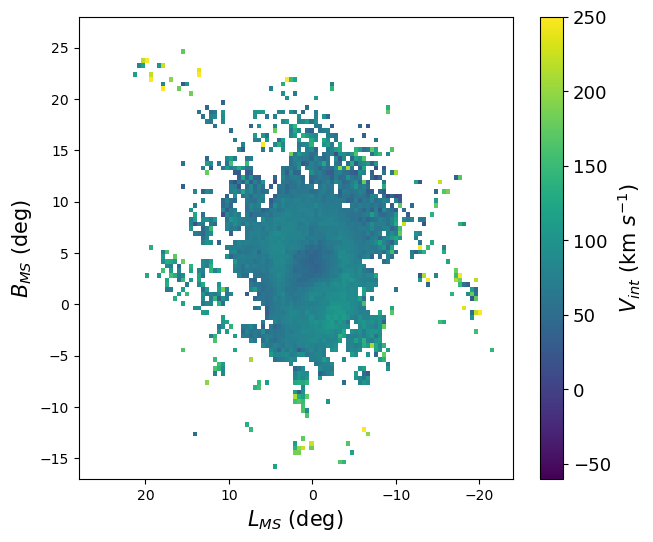

In [67]:
fig,ax = plt.subplots(1,1,figsize=(7,6))

result,xedge,yedge,binnumber = binned_statistic_2d(lmc_combined_for_fit['mlon'], lmc_combined_for_fit['mlat'],
                lmc_combined_for_fit['vint_cyl'], statistic = "mean",bins=90)

im = ax.imshow(result.T,extent=[xedge[0],xedge[-1],yedge[0],yedge[-1]], origin="lower", aspect="auto", cmap="viridis",vmin=-60,vmax=250)


ax.set_xlim(28,-24)
ax.set_ylim(-17,28)

cbar = plt.colorbar(im)
cbar.set_label('$V_{int}$ (km $s^{-1}$)', fontsize=15)
cbar.ax.tick_params(labelsize=13)

ax.set_xlabel('$L_{MS}$ (deg)', fontsize=15)
ax.set_ylabel('$B_{MS}$ (deg)', fontsize=15)


In [54]:
gaiadr3_RGB_lmc_smc = Table.read('/Users/slaterjonesoden/Desktop/LMC_Periphery/LMC_Periphery_Project/Gaia_dr3/full_catalog/combined/gaiadr3_RGB_lmc_smc.fits')



Text(0, 0.5, '$B_{MS}$ (deg)')

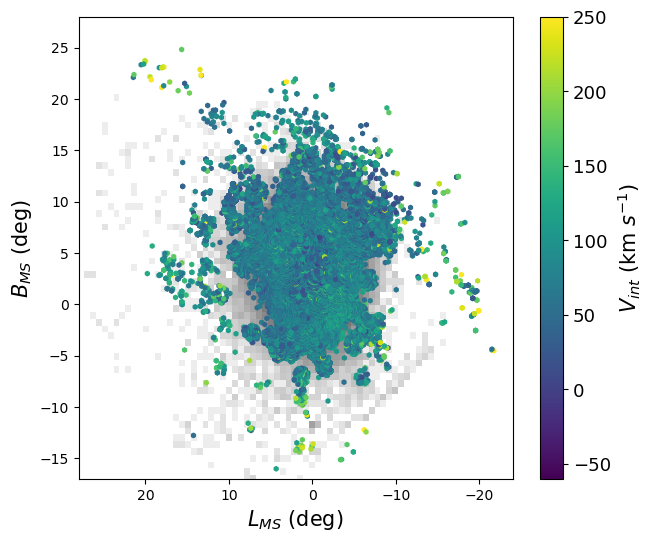

In [64]:
fig,ax = plt.subplots(1,1,figsize=(7,6))

# result,xedge,yedge,binnumber = binned_statistic_2d(lmc_combined_for_fit['mlon'], lmc_combined_for_fit['mlat'],
#                 lmc_combined_for_fit['vint'], statistic = "mean",bins=90)

# im = ax.imshow(result.T,extent=[xedge[0],xedge[-1],yedge[0],yedge[-1]], origin="lower", aspect="auto", cmap="viridis",vmin=-50,vmax=200)

plt.hist2d(gaiadr3_lmc_good['mlon'],gaiadr3_lmc_good['mlat'],norm=LogNorm(),bins=70,cmap='gray_r')

im = plt.scatter(lmc_combined_for_fit['mlon'], lmc_combined_for_fit['mlat'],
                c=lmc_combined_for_fit['vint_cyl'],cmap='viridis',marker='h',s=10,vmin=-60,vmax=250)

ax.set_xlim(28,-24)
ax.set_ylim(-17,28)

cbar = plt.colorbar(im)
cbar.set_label('$V_{int}$ (km $s^{-1}$)', fontsize=15)
cbar.ax.tick_params(labelsize=13)

ax.set_xlabel('$L_{MS}$ (deg)', fontsize=15)
ax.set_ylabel('$B_{MS}$ (deg)', fontsize=15)
